In [1]:
import obspy
from obspy.taup import TauPyModel

from multiprocessing import Pool
from obspy import read,UTCDateTime,Trace,Stream
from obspy.clients.fdsn import Client
import os
import glob
import shutil
import numpy as np
from collections import defaultdict
import pandas as pd
from scipy import signal


#para plotar as figuras
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition,inset_axes
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib.dates import YearLocator, MonthLocator, DayLocator, HourLocator, MinuteLocator, SecondLocator, DateFormatter
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib.gridspec as gridspec

from datetime import datetime,timedelta,date
from tqdm import tqdm

from shapely.geometry.polygon import LinearRing

import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [100]:
FOLDER_OUTPUT = '/run/media/diogoloc/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/OUTPUT/'

MSEED_INPUT = "data/"

EVENTs_DATA_FOLDER = '/home/dIOGOLOC/Documents/codes_marefone/EVENT_MSEED/'

SELECT_EVENTs_DATA_FOLDER = '/home/dIOGOLOC/Documents/codes_marefone/EVENT_MSEED_SEL/'

EVENTs_GLIDER_CSV = "/run/media/diogoloc/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/data_glider_information_csv/metadados_glider_acustico_pmpas-bs.csv"


# Extraindo informações dos arquivos ".mseed"

In [175]:
filenames_MSEED = sorted(glob.glob(MSEED_INPUT+'*_04*_*.mseed'))

In [176]:
filenames_MSEED

['data/pa0025au_040_160110_183418.mseed',
 'data/pa0025au_041_160110_183617.mseed']

In [177]:
def mseed_data_2_dataframe(i):
    subdir, filename_wav = os.path.split(i)
    filename = filename_wav.split('.mseed')[0]
    if 'pa' in filename.split('_')[0]:
        mergulho = filename.split('_')[0].split('a')[1]
        stream_number = filename.split('_')[1]

        year_month_day = filename.split('_')[2]
        hour_minute_second = filename.split('_')[3]

        year = int('20'+year_month_day[:2])
        month = int(year_month_day[2:4])
        day = int(year_month_day[4:])

        hour = int(hour_minute_second[:2])
        minute = int(hour_minute_second[2:4])
        second = int(hour_minute_second[4:])

        d = UTCDateTime(datetime(year,month,day,hour,minute,second).isoformat())


    if 'pa' in filename.split('_')[2]:

        mergulho = filename.split('_')[2].split('a')[1]
        stream_number = filename.split('_')[3]

        year_month_day = filename.split('_')[0]
        hour_minute_second = filename.split('_')[1]

        year = int('20'+year_month_day[:2])
        month = int(year_month_day[2:4])
        day = int(year_month_day[4:])

        hour = int(hour_minute_second[:2])
        minute = int(hour_minute_second[2:4])
        second = int(hour_minute_second[4:])

        d = UTCDateTime(datetime(year,month,day,hour,minute,second).isoformat())
        
    
    st = read(i)   
    #----------------------------
    #Starting Dataframe

    starttime = st[0].stats.starttime.datetime
    endtime = st[0].stats.endtime.datetime
    sampling = st[0].stats.sampling_rate
    npts = st[0].stats.npts
    
    df = pd.DataFrame([[i],[filename],[sampling],[npts],[mergulho],[stream_number],[starttime],[endtime]], index=['filepath','filename', 'sampling', 'npts', 'mergulho', 'stream_number','starttime','endtime']).T

    #Ending Dataframe
    #----------------------------
    return df

In [178]:
pandas_mseed_lst = []

with Pool(processes=1) as p:
    max_ = len(filenames_MSEED)
    with tqdm(total=max_) as pbar:
        for result in p.imap_unordered(mseed_data_2_dataframe,filenames_MSEED):
            pbar.update()
            pandas_mseed_lst.append(result)

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 62.56it/s]


In [179]:
dataframe_mseed_final = pd.concat(pandas_mseed_lst, ignore_index=True)
dataframe_mseed_final


,filepath,filename,sampling,npts,mergulho,stream_number,starttime,endtime
0,data/pa0025au_040_160110_183418.mseed,pa0025au_040_160110_183418,100.0,11994,0025,040,2016-01-10 18:34:18,2016-01-10 18:36:17.930
1,data/pa0025au_041_160110_183617.mseed,pa0025au_041_160110_183617,100.0,9995,0025,041,2016-01-10 18:36:17,2016-01-10 18:37:56.940


# Extraindo informações do arquivo ".csv"

In [180]:
dataframe_csv = pd.read_csv(EVENTs_GLIDER_CSV,parse_dates=['time'])
dataframe_csv.sort_values(by='time')

,time,filename,latitude,longitude,depth
0,2015-11-12 13:48:40.999995,pa0001au_001_151112_134841_rms_spl3.mat,-23.825157,-42.495483,1.314286
1,2015-11-12 13:49:41.000001,pa0001au_001_151112_134841_rms_spl3.mat,-23.824950,-42.495487,7.415555
2,2015-11-12 13:50:40.999998,pa0001au_002_151112_135041_rms_spl3.mat,-23.824745,-42.495490,15.776000
3,2015-11-12 13:51:41.000004,pa0001au_002_151112_135041_rms_spl3.mat,-23.824540,-42.495495,24.372000
4,2015-11-12 13:52:41.000001,pa0001au_003_151112_135241_rms_spl3.mat,-23.824331,-42.495500,32.912000
...,...,...,...,...,...
547748,2021-11-04 06:52:38.000000,pa0296au_011_211104_064338_rms_spl3.mat,-24.461742,-42.471264,866.012900
547749,2021-11-04 06:53:37.999997,pa0296au_012_211104_065338_rms_spl3.mat,-24.461819,-42.471302,873.586100
547750,2021-11-04 06:54:38.000003,pa0296au_012_211104_065338_rms_spl3.mat,-24.461980,-42.471510,879.579600
547751,2021-11-04 06:55:38.000000,pa0296au_012_211104_065338_rms_spl3.mat,-24.462152,-42.471740,884.380700


In [181]:
dataframe_csv['year'] = dataframe_csv['time'].dt.strftime("%Y")
dataframe_csv['month'] = dataframe_csv['time'].dt.strftime("%m")
dataframe_csv['n_month'] = dataframe_csv['time'].dt.strftime("%b")
dataframe_csv['depth'] = dataframe_csv['depth'] * -1

In [182]:
# Selecione as linhas onde as datas estejam dentro do intervalo
selecao = (dataframe_csv['time'] >= dataframe_mseed_final['starttime'].min()) & (dataframe_csv['time'] <= dataframe_mseed_final['endtime'].max())
dataframe_csv_sel = dataframe_csv.loc[selecao]

In [183]:
dataframe_csv_sel

,time,filename,latitude,longitude,depth,year,month,n_month
16443,2016-01-10 18:34:18.000002,pa0025au_040_160110_183418_rms_spl3.mat,-24.743559,-42.494340,-954.29870,2016,01,Jan
16444,2016-01-10 18:35:17.999998,pa0025au_040_160110_183418_rms_spl3.mat,-24.743860,-42.494335,-959.32800,2016,01,Jan
16445,2016-01-10 18:36:17.000000,pa0025au_041_160110_183617_rms_spl3.mat,-24.744156,-42.494335,-961.42535,2016,01,Jan
16446,2016-01-10 18:37:16.999997,pa0025au_041_160110_183617_rms_spl3.mat,-24.744457,-42.494330,-963.04400,2016,01,Jan


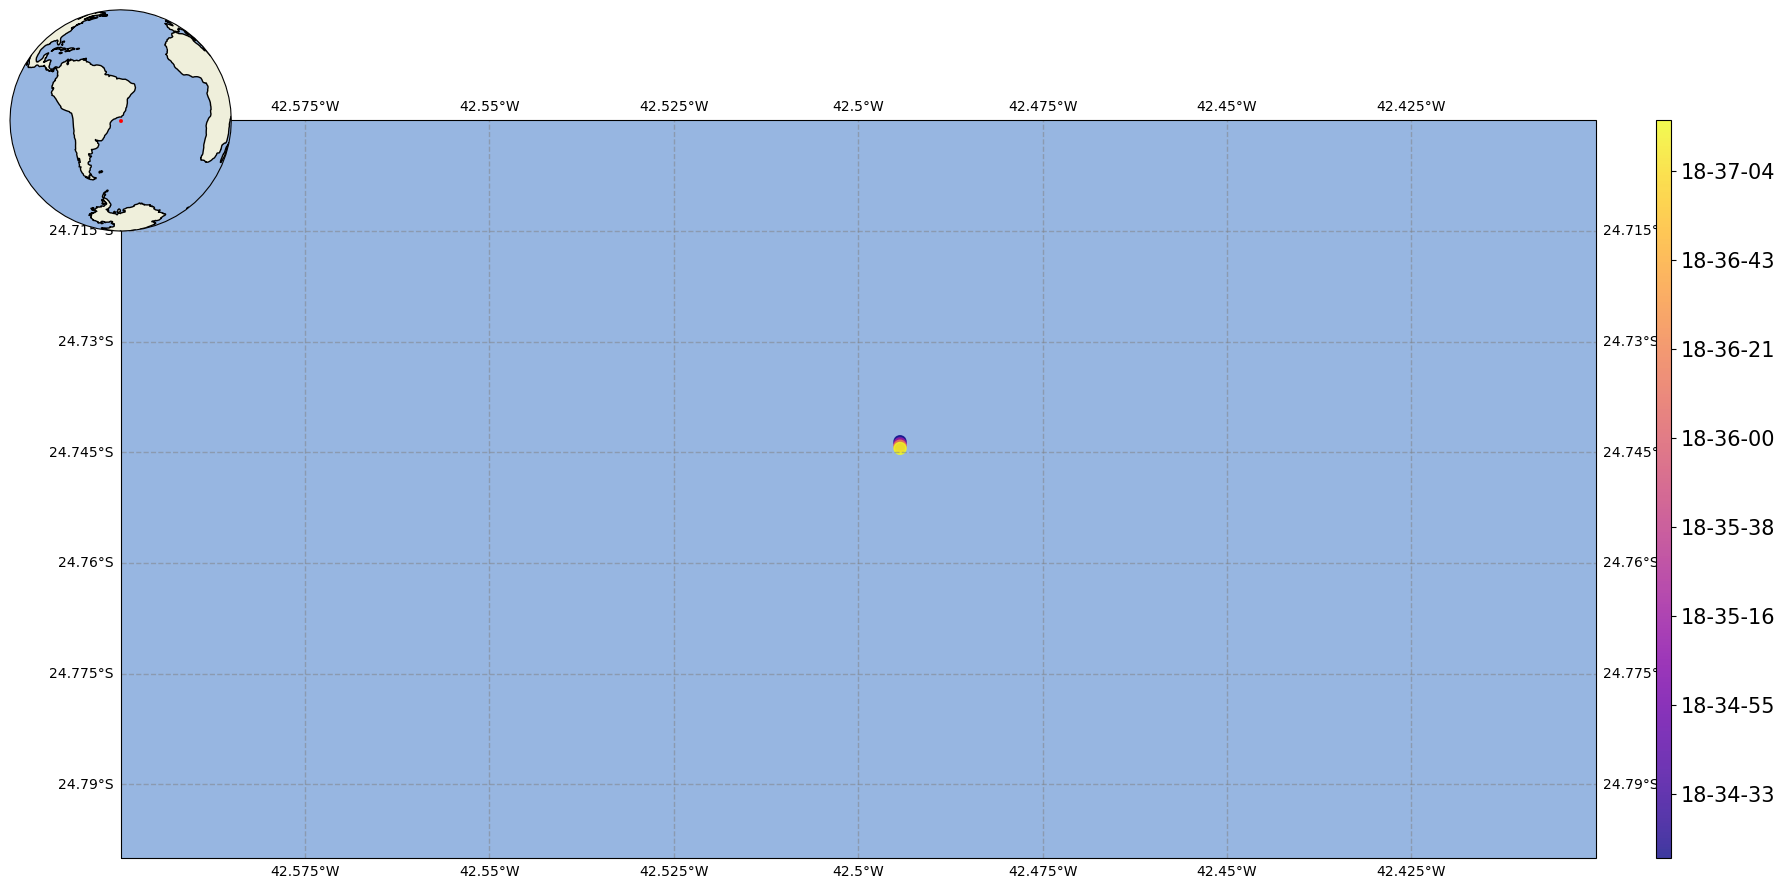

In [184]:
# Create a figure
# set up the plot and create a GeoAxes:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(1, 1,figsize=(20,10), subplot_kw=dict(projection=proj))

# ----------------------------------------------------------------------------------------------------------
# Limit the extent of the map to a small longitude/latitude range.
latmin=-24.8
latmax=-24.7
lonmin=-42.6
lonmax=-42.4

ax.set_extent([lonmin,lonmax, latmin, latmax], crs=ccrs.Geodetic())

# ----------------------------------------------------------------------------------------------------------
# Ploting lat/lon values

h = ax.scatter(dataframe_csv_sel['longitude'],dataframe_csv_sel['latitude'],c=np.array([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_csv_sel['time']]),marker='o',alpha=0.8,cmap='plasma',s=75,transform=proj)
# ----------------------------------------------------------------------------------------------------------
# Adding background map 
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE,linewidth=0.3)
ax.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')

# ----------------------------------------------------------------------------------------------------------
# Adding colorbar
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="1%", pad=0.6, axes_class=plt.Axes)

fig.add_axes(ax_cb)
cb = plt.colorbar(h, cax=ax_cb)
cb.ax.yaxis.set_major_formatter(mdates.DateFormatter('%H-%M-%S'))

#####################################################
# Adding inset axes LEFT
#####################################################

# ----------------------------------------------------------------------------------------------------------
# Adding global location map
# inset location relative to main plot (ax) in normalized units
inset_x = 0
inset_y = 1
inset_size = 0.3
# Adding Geoaxes
ax2 = plt.axes([0, 0, 1, 1], projection=ccrs.Orthographic(central_latitude=(latmin + latmax)/2,central_longitude=(lonmin + lonmax) / 2))
ax2.set_global()

# Adding background map 
ax2.add_feature(cfeature.LAND)
ax2.add_feature(cfeature.OCEAN)
ax2.add_feature(cfeature.COASTLINE)

# Adding inset geoaxes position
ip = InsetPosition(ax, [inset_x - inset_size / 2,
                        inset_y - inset_size / 2,
                        inset_size,
                        inset_size])
ax2.set_axes_locator(ip)


# Adding red rectangle position
nvert = 100
lons = np.r_[np.linspace(lonmin, lonmin, nvert),
             np.linspace(lonmin, lonmax, nvert),
             np.linspace(lonmax, lonmax, nvert)].tolist()
lats = np.r_[np.linspace(latmin, latmax, nvert),
             np.linspace(latmax, latmax, nvert),
             np.linspace(latmax, latmin, nvert)].tolist()

ring = LinearRing(list(zip(lons, lats)))
ax2.add_geometries([ring], ccrs.PlateCarree(),
                   facecolor='none', edgecolor='red', linewidth=2)



In [185]:
stream_amplitude = Stream()
for f in dataframe_mseed_final['filepath']:
    stream_amplitude += read(f)

In [186]:
stream_amplitude.merge(method=1,interpolation_samples=2)

1 Trace(s) in Stream:
... | 2016-01-10T18:34:18.000000Z - 2016-01-10T18:37:56.940000Z | 100.0 Hz, 21895 samples

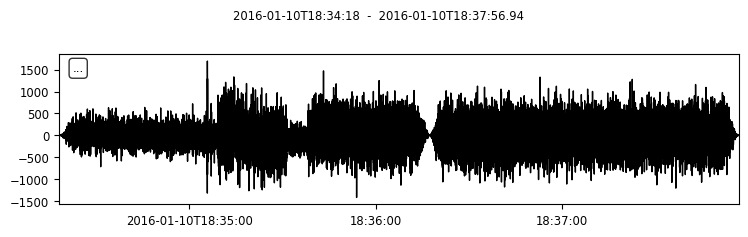

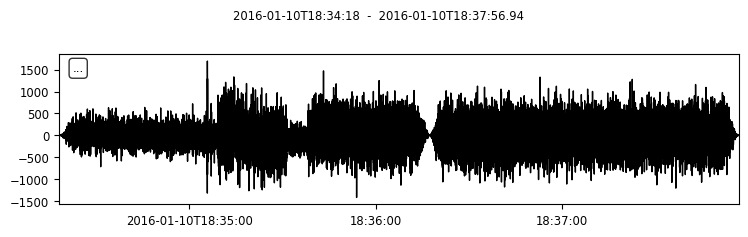

In [187]:
stream_amplitude.plot()

In [188]:
dataframe_mseed_final

,filepath,filename,sampling,npts,mergulho,stream_number,starttime,endtime
0,data/pa0025au_040_160110_183418.mseed,pa0025au_040_160110_183418,100.0,11994,0025,040,2016-01-10 18:34:18,2016-01-10 18:36:17.930
1,data/pa0025au_041_160110_183617.mseed,pa0025au_041_160110_183617,100.0,9995,0025,041,2016-01-10 18:36:17,2016-01-10 18:37:56.940


/tmp/ipykernel_5261/1628721740.py:36: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(2, 1, 1, projection=proj)


(16810.773819444443, 16810.77635347222)

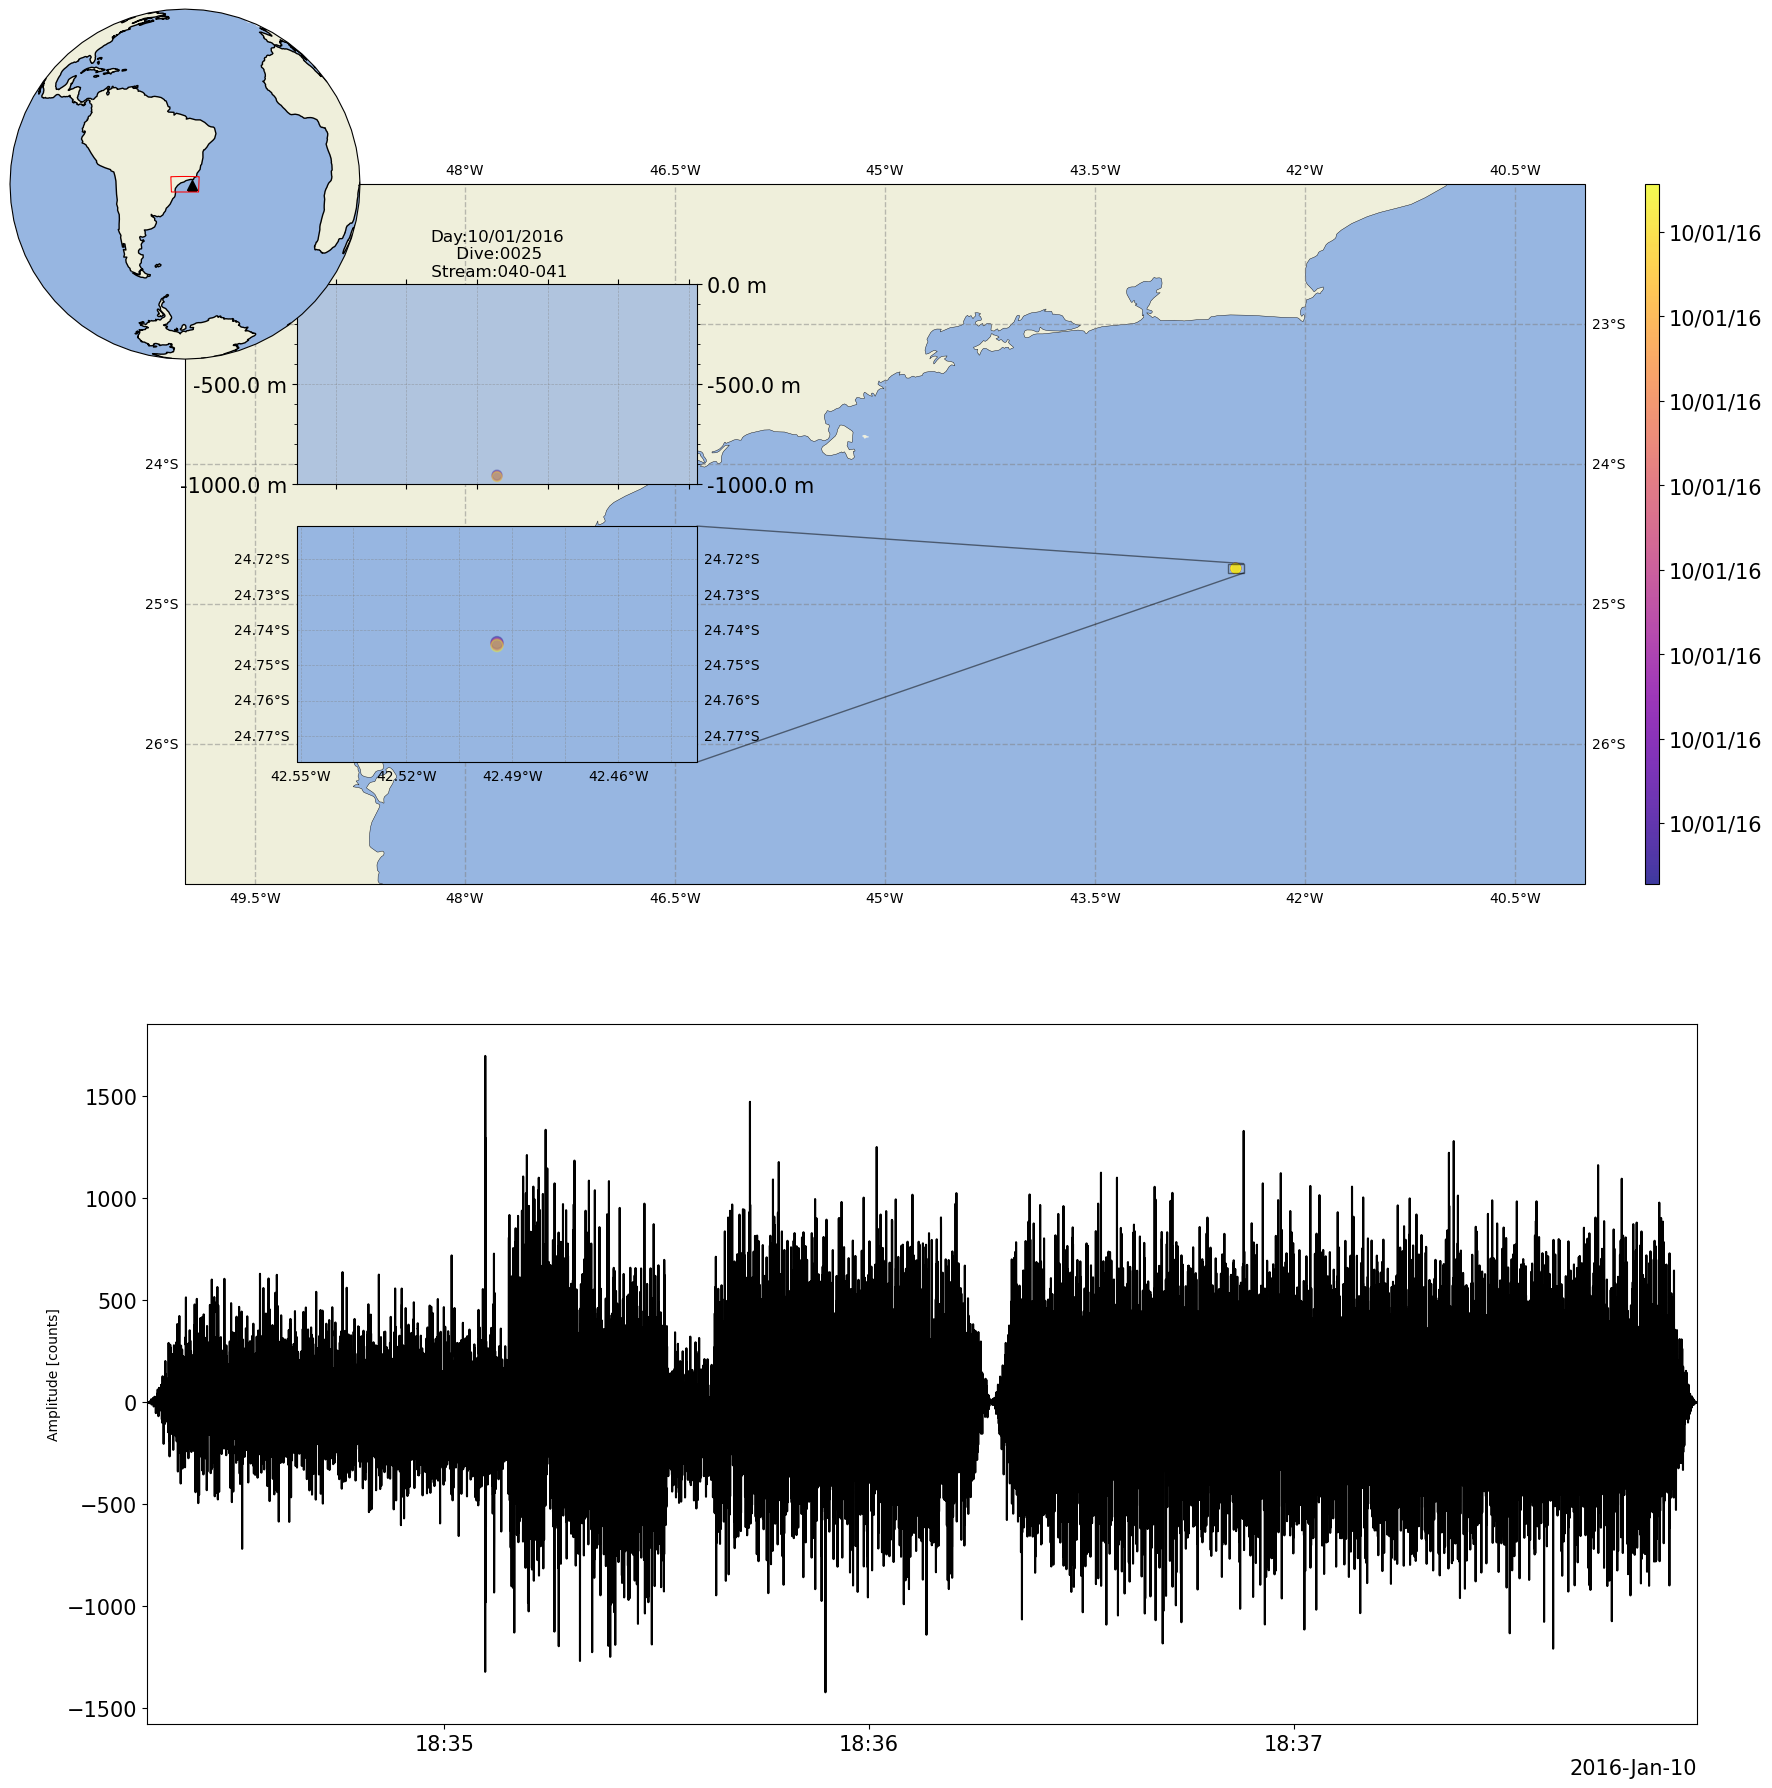

In [189]:
#########################################################################################################################################################
#STREAM 

stream_stream = Stream()
for f in dataframe_mseed_final['filepath']:
    stream_stream += read(f)
#stream_stream.merge(method=0)
stream_stream.merge(method=1,interpolation_samples=0)

stream_amplitude = stream_stream[0].data
stream_times = stream_stream[0].times('matplotlib')

file_mseed_event = {}
file_mseed_event['amplitude'] = stream_amplitude
file_mseed_event['time'] = stream_times

file_mseed_event = pd.DataFrame.from_dict(file_mseed_event)

#########################################################################################################################################################    
# Extracting some information
mergulho = dataframe_mseed_final['mergulho'].tolist()
stream_number = dataframe_mseed_final['stream_number'].tolist()

lat_event_info = dataframe_csv_sel['latitude'].values
lon_event_info = dataframe_csv_sel['longitude'].values        
depth_event_info = dataframe_csv_sel['depth'].values       
time_event_info = dataframe_csv_sel['time'].values                                        
#########################################################################################################################################################
#Figure 
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
# set up the plot and create a GeoAxes:
proj = ccrs.PlateCarree()

fig, (ax,ax1) = plt.subplots(2,1,figsize=(20,20))
ax = plt.subplot(2, 1, 1, projection=proj)

# ----------------------------------------------------------------------------------------------------------
# Limit the extent of the map to a small longitude/latitude range.
latmin=-27
latmax=-22
lonmin=-50
lonmax=-40

ax.set_extent([lonmin,lonmax, latmin, latmax], crs=ccrs.Geodetic())

# ----------------------------------------------------------------------------------------------------------
# Ploting lat/lon values

h = ax.scatter(dataframe_csv_sel['longitude'],dataframe_csv_sel['latitude'],c=np.array([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_csv_sel['time']]),marker='o',alpha=0.8,cmap='plasma',s=50,transform=proj)
# ----------------------------------------------------------------------------------------------------------
# Adding background map 
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE,linewidth=0.3)
ax.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')

# ----------------------------------------------------------------------------------------------------------
# Adding colorbar
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="1%", pad=0.6, axes_class=plt.Axes)

fig.add_axes(ax_cb)
cb = plt.colorbar(h, cax=ax_cb)
cb.ax.yaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%y'))

#####################################################
# Adding inset axes RIGHT
#####################################################

axins = plt.axes([0.2, 0.55, 0.2, 0.2],projection=proj)

axins.scatter(dataframe_csv_sel['longitude'],dataframe_csv_sel['latitude'],c=np.array([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_csv_sel['time']]),marker='o',alpha=0.3,cmap='plasma',s=75,transform=proj)

axins.add_feature(cfeature.LAND)
axins.add_feature(cfeature.OCEAN)
axins.add_feature(cfeature.COASTLINE,linewidth=0.3)
axins.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)
 
# ----------------------------------------------------------------------------------------------------------
# Adding grid 
axins.gridlines(crs=ccrs.PlateCarree(), draw_labels=["bottom", "left", "right"],linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
axins.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=True, labeltop=False, labelleft=True, labelright=True)

# subregion of the original image
x1 = np.min(lon_event_info)-abs(np.min(lon_event_info)/750)
x2 = np.max(lon_event_info)+abs(np.max(lon_event_info)/750)
y1 = np.min(lat_event_info)-abs(np.min(lat_event_info)/750)
y2 = np.max(lat_event_info)+abs(np.max(lat_event_info)/750)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

# ----------------------------------------------------------------------------------------------------------
# Adding ZOOM (vertical map)
ax.indicate_inset_zoom(axins, edgecolor="black")

# ============================================================================================================
ax_histx = plt.axes([0.2, 0.73, 0.2, 0.1],sharex=axins,facecolor='lightsteelblue')
ax_histx.scatter(lon_event_info,depth_event_info, c=time_event_info,marker='o',vmax=max(time_event_info),vmin=min(time_event_info),alpha=0.25,cmap='plasma',s=50)
ax_histx.grid(linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
ax_histx.set_title("Day:"+mdates.num2date(mdates.date2num(time_event_info[0])).strftime('%d/%m/%Y')+"\n Dive:"+mergulho[0]+"\n Stream:"+stream_number[0]+'-'+stream_number[-1])
ax_histx.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=False, labeltop=False, labelleft=True, labelright=True)
ax_histx.set_ylim(-1000,0)
ax_histx.yaxis.set_major_formatter('{x} m')
ax_histx.yaxis.set_major_locator(MultipleLocator(500))
ax_histx.yaxis.set_minor_locator(MultipleLocator(100))

# ============================================================================================================
# Adding global location map
# inset location relative to main plot (ax) in normalized units
inset_x = 0
inset_y = 1
inset_size = 0.5

# Adding Geoaxes
ax2 = plt.axes([0, 0, 1, 1], projection=ccrs.Orthographic(central_latitude=(latmin + latmax)/2,central_longitude=(lonmin + lonmax) / 2))
ax2.set_global()

# Adding background map 
ax2.add_feature(cfeature.LAND)
ax2.add_feature(cfeature.OCEAN)
ax2.add_feature(cfeature.COASTLINE)

# Adding inset geoaxes position
ip = InsetPosition(ax, [inset_x - inset_size / 2,
                                            inset_y - inset_size / 2,
                                            inset_size,
                                            inset_size])
ax2.set_axes_locator(ip)
    
# Adding red rectangle position
nvert = 100
lons = np.r_[np.linspace(lonmin, lonmin, nvert),
                                 np.linspace(lonmin, lonmax, nvert),
                                 np.linspace(lonmax, lonmax, nvert)].tolist()
lats = np.r_[np.linspace(latmin, latmax, nvert),
                                 np.linspace(latmax, latmax, nvert),
                                 np.linspace(latmax, latmin, nvert)].tolist()

ring = LinearRing(list(zip(lons, lats)))
ax2.add_geometries([ring], ccrs.PlateCarree(),facecolor='none', edgecolor='red', linewidth=0.75)

ax2.scatter(np.mean(lon_event_info),np.mean(lat_event_info),color="k",marker='^',s=50,transform=ccrs.PlateCarree())

# ================================================================================================================
# Adding stream plot

ax1.plot(file_mseed_event['time'].values,file_mseed_event['amplitude'].values,'-k')        
ax1.set_ylabel('Amplitude [counts]')
locator = mdates.AutoDateLocator(minticks=9, maxticks=14)
formatter = mdates.ConciseDateFormatter(locator)
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)
mins2 = MinuteLocator(interval=1)
mins1 = MinuteLocator(interval=1)
ax1.xaxis.set_major_locator(mins2)
ax1.xaxis.set_minor_locator(mins1)
ax1.set_xlim(file_mseed_event['time'].values[0],file_mseed_event['time'].values[-1])

In [190]:
dataframe_mseed_final['endtime'].values

array(['2016-01-10T18:36:17.930000000', '2016-01-10T18:37:56.940000000'],
      dtype='datetime64[ns]')

# Plotando as formas de onda

/tmp/ipykernel_5261/3827952745.py:36: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(2, 1, 1, projection=proj)


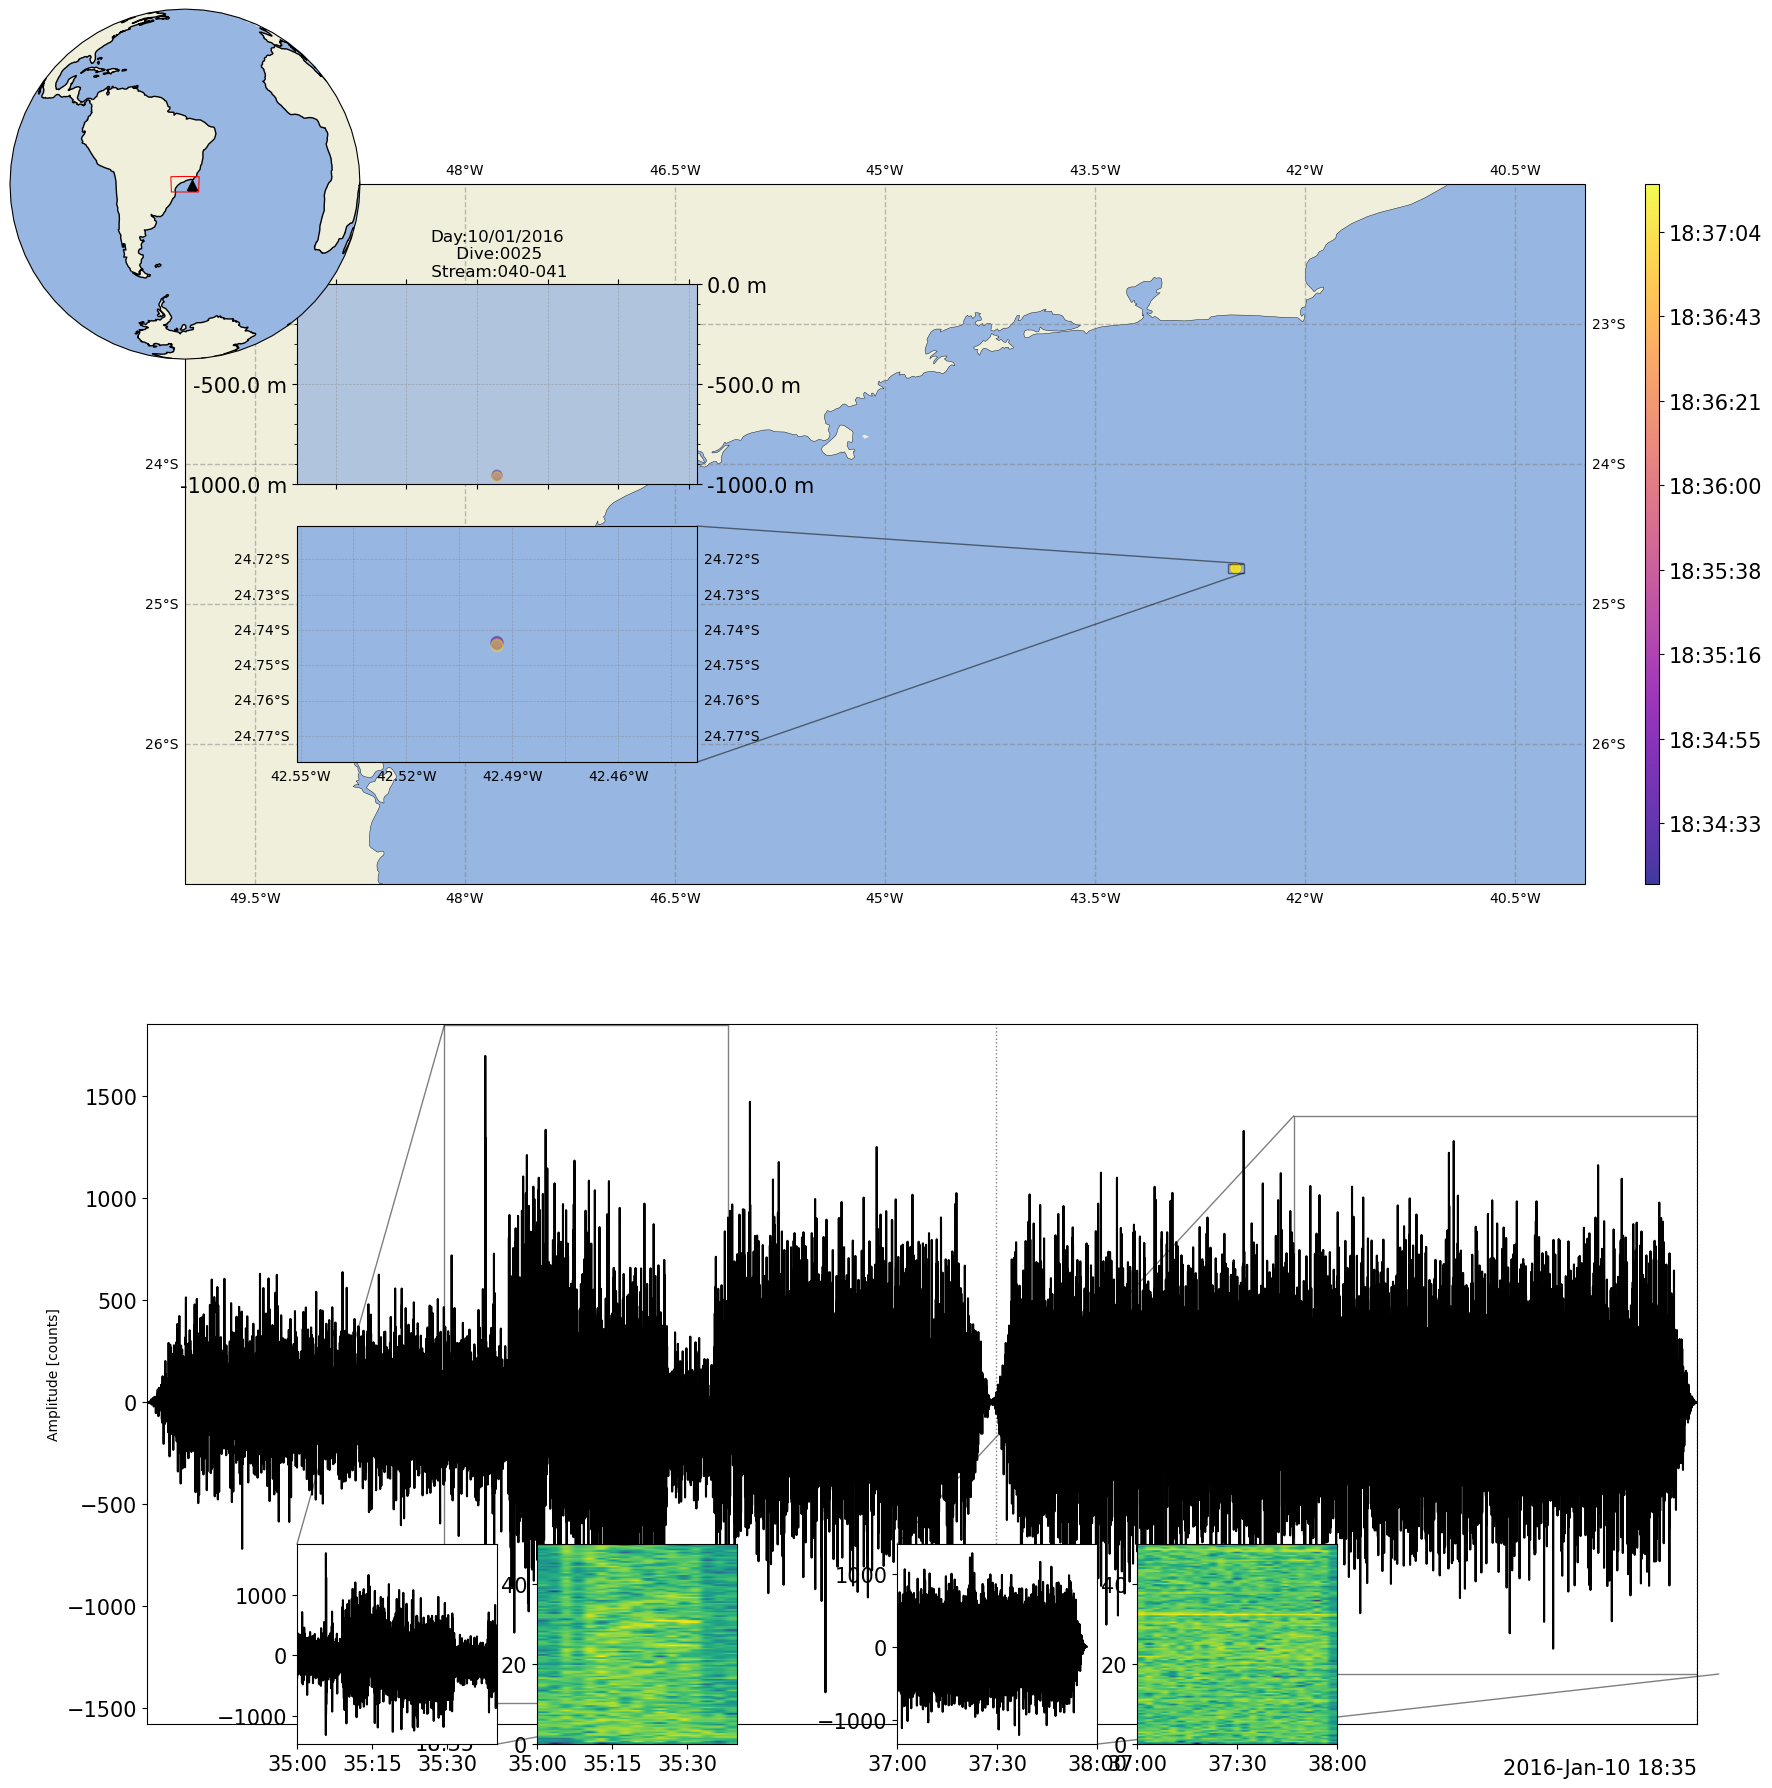

In [191]:
#########################################################################################################################################################
#STREAM 

stream_stream = Stream()
for f in dataframe_mseed_final['filepath']:
    stream_stream += read(f)
#stream_stream.merge(method=0)
stream_stream.merge(method=1,interpolation_samples=0)

stream_amplitude = stream_stream[0].data
stream_times = stream_stream[0].times('matplotlib')

file_mseed_event = {}
file_mseed_event['amplitude'] = stream_amplitude
file_mseed_event['time'] = stream_times

file_mseed_event = pd.DataFrame.from_dict(file_mseed_event)

#########################################################################################################################################################    
# Extracting some information
mergulho = dataframe_mseed_final['mergulho'].tolist()
stream_number = dataframe_mseed_final['stream_number'].tolist()

lat_event_info = dataframe_csv_sel['latitude'].values
lon_event_info = dataframe_csv_sel['longitude'].values        
depth_event_info = dataframe_csv_sel['depth'].values       
time_event_info = dataframe_csv_sel['time'].values                                        
#########################################################################################################################################################
#Figure 
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
# set up the plot and create a GeoAxes:
proj = ccrs.PlateCarree()

fig, (ax,ax1) = plt.subplots(2,1,figsize=(20,20))
ax = plt.subplot(2, 1, 1, projection=proj)

# ----------------------------------------------------------------------------------------------------------
# Limit the extent of the map to a small longitude/latitude range.
latmin=-27
latmax=-22
lonmin=-50
lonmax=-40

ax.set_extent([lonmin,lonmax, latmin, latmax], crs=ccrs.Geodetic())

# ----------------------------------------------------------------------------------------------------------
# Ploting lat/lon values

h = ax.scatter(dataframe_csv_sel['longitude'],dataframe_csv_sel['latitude'],c=np.array([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_csv_sel['time']]),marker='o',alpha=0.8,cmap='plasma',s=50,transform=proj)
# ----------------------------------------------------------------------------------------------------------
# Adding background map 
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE,linewidth=0.3)
ax.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')

# ----------------------------------------------------------------------------------------------------------
# Adding colorbar
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="1%", pad=0.6, axes_class=plt.Axes)

fig.add_axes(ax_cb)
cb = plt.colorbar(h, cax=ax_cb)
cb.ax.yaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

#####################################################
# Adding inset axes RIGHT
#####################################################

axins = plt.axes([0.2, 0.55, 0.2, 0.2],projection=proj)

axins.scatter(dataframe_csv_sel['longitude'],dataframe_csv_sel['latitude'],c=np.array([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_csv_sel['time']]),marker='o',alpha=0.3,cmap='plasma',s=75,transform=proj)

axins.add_feature(cfeature.LAND)
axins.add_feature(cfeature.OCEAN)
axins.add_feature(cfeature.COASTLINE,linewidth=0.3)
axins.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)
 
# ----------------------------------------------------------------------------------------------------------
# Adding grid 
axins.gridlines(crs=ccrs.PlateCarree(), draw_labels=["bottom", "left", "right"],linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
axins.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=True, labeltop=False, labelleft=True, labelright=True)

# subregion of the original image
x1 = np.min(lon_event_info)-abs(np.min(lon_event_info)/750)
x2 = np.max(lon_event_info)+abs(np.max(lon_event_info)/750)
y1 = np.min(lat_event_info)-abs(np.min(lat_event_info)/750)
y2 = np.max(lat_event_info)+abs(np.max(lat_event_info)/750)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

# ----------------------------------------------------------------------------------------------------------
# Adding ZOOM (vertical map)
ax.indicate_inset_zoom(axins, edgecolor="black")

# ============================================================================================================
ax_histx = plt.axes([0.2, 0.73, 0.2, 0.1],sharex=axins,facecolor='lightsteelblue')
ax_histx.scatter(lon_event_info,depth_event_info, c=time_event_info,marker='o',vmax=max(time_event_info),vmin=min(time_event_info),alpha=0.25,cmap='plasma',s=50)
ax_histx.grid(linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
ax_histx.set_title("Day:"+mdates.num2date(mdates.date2num(time_event_info[0])).strftime('%d/%m/%Y')+"\n Dive:"+mergulho[0]+"\n Stream:"+stream_number[0]+'-'+stream_number[-1])
ax_histx.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=False, labeltop=False, labelleft=True, labelright=True)
ax_histx.set_ylim(-1000,0)
ax_histx.yaxis.set_major_formatter('{x} m')
ax_histx.yaxis.set_major_locator(MultipleLocator(500))
ax_histx.yaxis.set_minor_locator(MultipleLocator(100))

# ============================================================================================================
# Adding global location map
# inset location relative to main plot (ax) in normalized units
inset_x = 0
inset_y = 1
inset_size = 0.5

# Adding Geoaxes
ax2 = plt.axes([0, 0, 1, 1], projection=ccrs.Orthographic(central_latitude=(latmin + latmax)/2,central_longitude=(lonmin + lonmax) / 2))
ax2.set_global()

# Adding background map 
ax2.add_feature(cfeature.LAND)
ax2.add_feature(cfeature.OCEAN)
ax2.add_feature(cfeature.COASTLINE)

# Adding inset geoaxes position
ip = InsetPosition(ax, [inset_x - inset_size / 2,
                                            inset_y - inset_size / 2,
                                            inset_size,
                                            inset_size])
ax2.set_axes_locator(ip)
    
# Adding red rectangle position
nvert = 100
lons = np.r_[np.linspace(lonmin, lonmin, nvert),
                                 np.linspace(lonmin, lonmax, nvert),
                                 np.linspace(lonmax, lonmax, nvert)].tolist()
lats = np.r_[np.linspace(latmin, latmax, nvert),
                                 np.linspace(latmax, latmax, nvert),
                                 np.linspace(latmax, latmin, nvert)].tolist()

ring = LinearRing(list(zip(lons, lats)))
ax2.add_geometries([ring], ccrs.PlateCarree(),facecolor='none', edgecolor='red', linewidth=0.75)

ax2.scatter(np.mean(lon_event_info),np.mean(lat_event_info),color="k",marker='^',s=50,transform=ccrs.PlateCarree())

# ================================================================================================================
# Adding stream plot

ax1.plot(file_mseed_event['time'].values,file_mseed_event['amplitude'].values,'-k')        
ax1.set_ylabel('Amplitude [counts]')
locator = mdates.AutoDateLocator(minticks=9, maxticks=14)
formatter = mdates.ConciseDateFormatter(locator)
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)
mins2 = MinuteLocator(interval=5)
mins1 = MinuteLocator(interval=1)
ax1.xaxis.set_major_locator(mins2)
ax1.xaxis.set_minor_locator(mins1)
ax1.set_xlim(file_mseed_event['time'].values[0],file_mseed_event['time'].values[-1])
for dc,date_camp in enumerate(dataframe_mseed_final['endtime'].values):
    ax1.axvline(x = date_camp, color='k', ls=':',lw=1,alpha=0.5)
    #ax.text(date_camp, 24.5, campanha_dic_labels[dc], horizontalalignment='center',rotation=45)
    
#################################
# Adding inset STREAM PLOT NOISE
#################################

noise_window_start = mdates.date2num(datetime(2016, 1, 10, 18, 35, 0))
noise_window_end = mdates.date2num(datetime(2016, 1, 10, 18, 35, 40))

selecao_noise = (file_mseed_event['time'] >= noise_window_start) & (file_mseed_event['time'] <= noise_window_end)
data_slice = file_mseed_event.loc[selecao_noise]

ax_glider_noise = plt.axes([0.2, 0.1, 0.1, 0.1])

ax_glider_noise.plot(data_slice['time'].values,data_slice['amplitude'].values,'-k')        
ax_glider_noise.set_xlim(noise_window_start,noise_window_end)
locator1 = mdates.AutoDateLocator(minticks=2, maxticks=4)
formatter = mdates.DateFormatter('%M:%S')

ax_glider_noise.xaxis.set_major_locator(locator1)
ax_glider_noise.xaxis.set_major_formatter(formatter)
# ----------------------------------------------------------------------------------------------------------
# Adding ZOOM (vertical map)
ax1.indicate_inset_zoom(ax_glider_noise, edgecolor="black")

#############################################
# Adding inset STREAM PLOT NOISE SPECTROGRAM
#############################################

ax_glider_noise_spectrogram = plt.axes([0.32, 0.1, 0.1, 0.1])

# Suponha que sua série temporal tenha sido amostrada a uma taxa de 100 Hz
fs = 100  # Frequência de amostragem (100 amostras por segundo)
signal_data = data_slice['amplitude'].values

# Calcular o espectrograma
frequencies, times, Sxx = signal.spectrogram(signal_data, fs)

# Plotar o espectrograma com os limites de tempo
ax_glider_noise_spectrogram.imshow(10 * np.log10(Sxx),extent=[noise_window_start,noise_window_end, 0, 50],aspect='auto',origin='lower')
ax_glider_noise_spectrogram.xaxis.set_major_locator(locator1)
ax_glider_noise_spectrogram.xaxis.set_major_formatter(formatter)


# ================================================================================================================
################################
# Adding inset STREAM PLOT EVENT
################################

noise_window_start1 = mdates.date2num(datetime(2016, 1, 10, 18, 37, 0))
noise_window_end1 = mdates.date2num(datetime(2016, 1, 10, 18, 38, 0))

selecao_noise = (file_mseed_event['time'] >= noise_window_start1) & (file_mseed_event['time'] <= noise_window_end1)
data_slice = file_mseed_event.loc[selecao_noise]

ax_glider_noise = plt.axes([0.5, 0.1, 0.1, 0.1])

ax_glider_noise.plot(data_slice['time'].values,data_slice['amplitude'].values,'-k')        
ax_glider_noise.set_xlim(noise_window_start1,noise_window_end1)
locator1 = mdates.AutoDateLocator(minticks=2, maxticks=4)
formatter = mdates.DateFormatter('%M:%S')

ax_glider_noise.xaxis.set_major_locator(locator1)
ax_glider_noise.xaxis.set_major_formatter(formatter)
# ----------------------------------------------------------------------------------------------------------
# Adding ZOOM (vertical map)
ax1.indicate_inset_zoom(ax_glider_noise, edgecolor="black")

#############################################
# Adding inset STREAM PLOT EVENT SPECTROGRAM
#############################################

ax_glider_noise_spectrogram = plt.axes([0.62, 0.1, 0.1, 0.1])

# Suponha que sua série temporal tenha sido amostrada a uma taxa de 100 Hz
fs = 100  # Frequência de amostragem (100 amostras por segundo)
signal_data = data_slice['amplitude'].values

# Calcular o espectrograma
frequencies, times, Sxx = signal.spectrogram(signal_data, fs)

# Plotar o espectrograma com os limites de tempo
ax_glider_noise_spectrogram.imshow(10 * np.log10(Sxx),extent=[noise_window_start1,noise_window_end1, 0, 50],aspect='auto',origin='lower')
ax_glider_noise_spectrogram.xaxis.set_major_locator(locator1)
ax_glider_noise_spectrogram.xaxis.set_major_formatter(formatter)
# ================================================================================================================
# Saving figure
os.makedirs(FOLDER_OUTPUT+'FIGURAS/TEST_MSEED/',exist_ok=True)
#fig.savefig(FOLDER_OUTPUT+'FIGURAS/TEST_MSEED/event_mseed_'+mdates.num2date(mdates.date2num(time_event_info[0])).strftime('%Y_%m_%d_%H_%M_%S')+'.png')